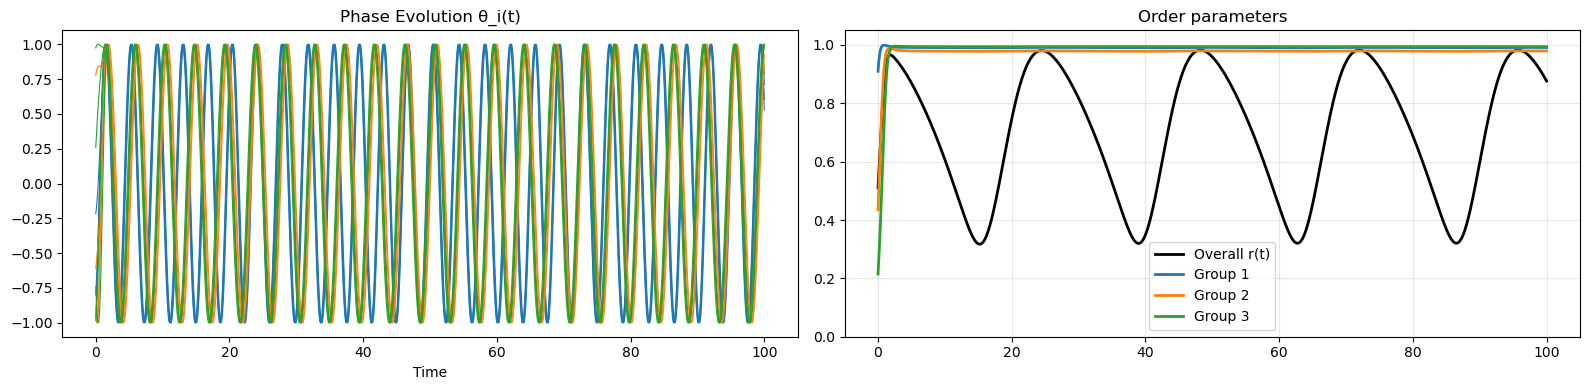

Model initialized on mps
Epoch 5/50 | Train Loss: 0.001167 | Val Loss: 0.000762
Epoch 10/50 | Train Loss: 0.000562 | Val Loss: 0.000375
Epoch 15/50 | Train Loss: 0.000377 | Val Loss: 0.000304
Epoch 20/50 | Train Loss: 0.000336 | Val Loss: 0.000295
Epoch 25/50 | Train Loss: 0.000244 | Val Loss: 0.000211
Epoch 30/50 | Train Loss: 0.000284 | Val Loss: 0.000267
Epoch 35/50 | Train Loss: 0.000214 | Val Loss: 0.000189
Epoch 40/50 | Train Loss: 0.000220 | Val Loss: 0.000180
Epoch 45/50 | Train Loss: 0.000221 | Val Loss: 0.000196
Epoch 50/50 | Train Loss: 0.000151 | Val Loss: 0.000154


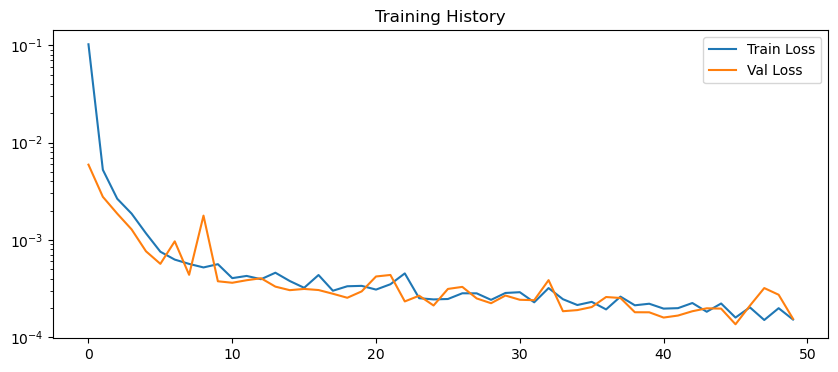

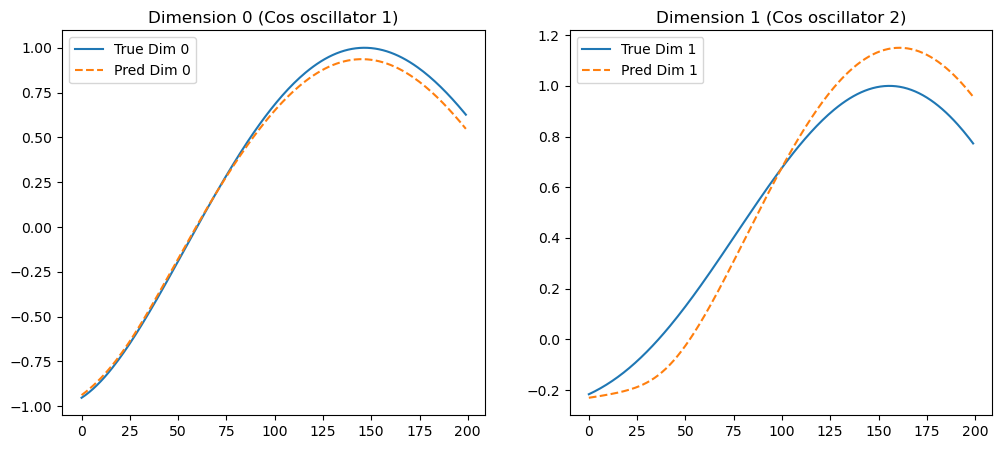

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from data_func import plot_clustered_kuramoto

# ==========================================
# 1. Kuramoto 数据生成部分
# ==========================================
N=12
n_clusters=3  # 团数
K_intra=5
K_inter=0.1
noise=0
dt=0.01
x_train, theta_hist, t_train, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=100,
    random_seed1=0, random_seed2=0,
    dt=dt
)
x_data = x_train
# ==========================================
# 2. 模型定义 (复用之前的重构代码)
# ==========================================
class KoopmanLayer(nn.Module):
    def __init__(self, in_features, out_features, activation='relu'):
        super(KoopmanLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        x = self.linear(x)
        if self.activation == 'relu': return F.relu(x)
        elif self.activation == 'tanh': return torch.tanh(x)
        elif self.activation == 'linear': return x
        return x

class MLP(nn.Module):
    def __init__(self, widths, activation='relu'):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(widths) - 1):
            act = activation if i < len(widths) - 2 else 'linear'
            layers.append(KoopmanLayer(widths[i], widths[i+1], act))
        self.net = nn.Sequential(*layers)

    def forward(self, x): return self.net(x)

class DeepKoopman(nn.Module):
    def __init__(self, params):
        super(DeepKoopman, self).__init__()
        self.params = params
        self.delta_t = params['delta_t']
        self.num_real = params['num_real']
        self.num_complex_pairs = params['num_complex_pairs']
        
        # Encoder
        self.encoder = MLP(params['widths'], params['act_type'])
        
        # Decoder (Reverse widths)
        decoder_widths = params['widths'][::-1]
        self.decoder = MLP(decoder_widths, params['act_type'])

        # Omega Nets
        self.omega_complex_nets = nn.ModuleList()
        self.omega_real_nets = nn.ModuleList()

        for _ in range(self.num_complex_pairs):
            widths = params['widths_omega_complex'].copy()
            if widths[0] != 1: widths.insert(0, 1) 
            self.omega_complex_nets.append(MLP(widths, params['act_type']))

        for _ in range(self.num_real):
            widths = params['widths_omega_real'].copy()
            if widths[0] != 1: widths.insert(0, 1)
            self.omega_real_nets.append(MLP(widths, params['act_type']))

    def get_omegas(self, y):
        omega_outputs = []
        # Complex pairs
        for j in range(self.num_complex_pairs):
            ind = 2 * j
            pair = y[:, ind:ind + 2]
            r2 = torch.sum(pair**2, dim=1, keepdim=True)
            omega_outputs.append(self.omega_complex_nets[j](r2))
        # Real
        for j in range(self.num_real):
            ind = 2 * self.num_complex_pairs + j
            y_val = y[:, ind:ind+1]
            omega_outputs.append(self.omega_real_nets[j](y_val))
        return omega_outputs

    def varying_multiply(self, y, omegas_params):
        parts = []
        # Complex
        for j in range(self.num_complex_pairs):
            ind = 2 * j
            y_pair = y[:, ind:ind+2].unsqueeze(2) # [B, 2, 1]
            param = omegas_params[j] # [B, 2] -> freq, scale
            
            scale = torch.exp(param[:, 1] * self.delta_t)
            c = torch.cos(param[:, 0] * self.delta_t)
            s = torch.sin(param[:, 0] * self.delta_t)
            
            row1 = torch.stack([c, -s], dim=1)
            row2 = torch.stack([s, c], dim=1)
            L = torch.stack([row1, row2], dim=1) * scale.unsqueeze(1).unsqueeze(2)
            
            parts.append(torch.bmm(L, y_pair).squeeze(2))
            
        # Real
        start_idx = 2 * self.num_complex_pairs
        for j in range(self.num_real):
            ind = start_idx + j
            factor = torch.exp(omegas_params[self.num_complex_pairs + j] * self.delta_t)
            parts.append(y[:, ind:ind+1] * factor)
            
        if not parts: return torch.zeros_like(y)
        return torch.cat(parts, dim=1)

    def forward(self, x, shifts):
        # x shape: [Batch, Time, Features]
        # x0 shape: [Batch, Features]
        x0 = x[:, 0, :]
        g = self.encoder(x0)
        
        y_recon_list = [self.decoder(g)] # t=0
        
        curr_g = g
        max_shift = max(shifts) if shifts else 0
        
        for step in range(1, max_shift + 1):
            omegas = self.get_omegas(curr_g)
            curr_g = self.varying_multiply(curr_g, omegas)
            
            if step in shifts:
                y_recon_list.append(self.decoder(curr_g))
                
        return y_recon_list, g


def prepare_dataloader(data, context_len, shifts, batch_size=64):
    """
    将单条轨迹切片成 [Batch, Max_Time_Step + 1, Features]
    """
    max_step = max(shifts)
    num_samples = len(data) - max_step
    
    X = []
    # 我们需要 t=0, t=shift1, t=shift2...
    # 但为了通用，我们截取连续的片段 [t, t+1, ..., t+max_shift]
    # 这样可以在 loss 中访问任意时刻
    
    for i in range(num_samples):
        # 截取长度为 max_step + 1 的序列
        window = data[i : i + max_step + 1]
        X.append(window)
        
    X = np.array(X) # [Samples, Time, Features]
    
    # 转 Tensor
    dataset = TensorDataset(torch.from_numpy(X).double())
    
    # 划分 Train/Val
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

def loss_fn(x_inputs, y_preds, g_list, model, params):
    # 1. Reconstruction (t=0)
    x0 = x_inputs[:, 0, :]
    loss_recon = F.mse_loss(y_preds[0], x0)
    
    # 2. Prediction (Future)
    loss_pred = 0.0
    for i, shift in enumerate(params['shifts']):
        x_target = x_inputs[:, shift, :]
        y_pred = y_preds[i+1]
        loss_pred += F.mse_loss(y_pred, x_target)
    loss_pred /= len(params['shifts'])
    
    # 3. Linearity (Optional, simple version)
    # 确保 g(t+1) 接近 encoder(x(t+1))
    loss_lin = 0.0
    # 获取 encoder 得到的真实 g_future
    # 假设 shifts=[1, ...]，我们只检查第一步线性度
    g0 = g_list[0]
    # 演化一步
    omegas = model.get_omegas(g0)
    g_next_pred = model.varying_multiply(g0, omegas)
    
    # 真实的 g_next
    # 注意：x_inputs[:, 1, :] 对应 t=1
    g_next_true = model.encoder(x_inputs[:, 1, :])
    loss_lin = F.mse_loss(g_next_pred, g_next_true)
    
    total_loss = params['lam_recon']*loss_recon + params['lam_pred']*loss_pred + params['lam_lin']*loss_lin
    return total_loss, loss_recon, loss_pred


# --- 设置 ---
N_OSCILLATORS = 12
# 数据是 [cos, sin]，所以输入维度是 2 * N
INPUT_DIM = 2 * N_OSCILLATORS 

# 预测未来多少步
SHIFTS = [1, 5, 10]

params = {
    'd': INPUT_DIM,
    'delta_t': 0.05,
    # 网络结构
    'widths': [INPUT_DIM, 64, 32, 6], # Encoder: Input -> 64 -> 32 -> 6 (Latent)
    'act_type': 'tanh', # 平滑激活函数通常对动力系统更好
    
    # Latent Space 结构 (Total dim = 2*complex + real = 2*2 + 2 = 6)
    'num_complex_pairs': 2,
    'num_real': 2,
    
    'widths_omega_complex': [1, 16, 2],
    'widths_omega_real': [1, 16, 1],
    
    'shifts': SHIFTS,
    
    # Loss 权重
    'lam_recon': 1.0,
    'lam_pred': 1.0,
    'lam_lin': 0.1,
    
    'lr': 1e-3,
    'epochs': 50
}

# --- 1. 数据准备 ---
train_loader, val_loader = prepare_dataloader(x_data, max(SHIFTS), SHIFTS, batch_size=32)

# --- 2. 模型初始化 ---
model = DeepKoopman(params)
model.double() # 高精度

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.float().to(device)
print(f"Model initialized on {device}")

optimizer = optim.Adam(model.parameters(), lr=params['lr'])

# --- 3. 训练循环 ---
history = {'train_loss': [], 'val_loss': []}

for epoch in range(params['epochs']):
    model.train()
    train_loss_avg = 0
    
    for batch_x in train_loader:
        batch_x = batch_x[0].float().to(device) # [B, T, D]
        
        optimizer.zero_grad()
        
        # Forward
        # g_list 这里简化处理，只传 g0，复杂的 g_list 逻辑见上面的 loss_fn
        preds, g0 = model(batch_x, SHIFTS)
        g_list = [g0] 
        
        loss, l_rec, l_pred = loss_fn(batch_x, preds, g_list, model, params)
        
        loss.backward()
        optimizer.step()
        
        train_loss_avg += loss.item()
        
    train_loss_avg /= len(train_loader)
    history['train_loss'].append(train_loss_avg)
    
    # Validation
    model.eval()
    val_loss_avg = 0
    with torch.no_grad():
        for batch_x in val_loader:
            batch_x = batch_x[0].float().to(device)
            preds, g0 = model(batch_x, SHIFTS)
            g_list = [g0]
            loss, _, _ = loss_fn(batch_x, preds, g_list, model, params)
            val_loss_avg += loss.item()
    val_loss_avg /= len(val_loader)
    history['val_loss'].append(val_loss_avg)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{params['epochs']} | Train Loss: {train_loss_avg:.6f} | Val Loss: {val_loss_avg:.6f}")

# --- 4. 结果可视化 ---
plt.figure(figsize=(10, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.yscale('log')
plt.legend()
plt.show()

# 验证效果: 预测未来
# 取一段验证数据
model.eval()
test_idx = 0
# 重新获取一段完整数据做长时预测
T_test = 200
test_data = x_data[0:T_test] # [T, D]
test_tensor = torch.from_numpy(test_data).float().unsqueeze(0).to(device) # [1, T, D]

# 真正的长时递归预测
pred_traj = []
curr_x = test_tensor[:, 0, :] # t=0


with torch.no_grad():
    # Encode initial state
    g = model.encoder(curr_x)
    rec_x0 = model.decoder(g)
    pred_traj.append(rec_x0.cpu().numpy())
    
    # Evolve in latent space
    for t in range(T_test - 1):
        omegas = model.get_omegas(g)
        g = model.varying_multiply(g, omegas)
        x_next = model.decoder(g)
        pred_traj.append(x_next.cpu().numpy())
        
pred_traj = np.array(pred_traj).squeeze() # [T, D]

# 绘图对比前两个维度 (Cos_0, Sin_0)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(test_data[:, 0], label='True Dim 0')
plt.plot(pred_traj[:, 0], '--', label='Pred Dim 0')
plt.title('Dimension 0 (Cos oscillator 1)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_data[:, 1], label='True Dim 1')
plt.plot(pred_traj[:, 1], '--', label='Pred Dim 1')
plt.title('Dimension 1 (Cos oscillator 2)')
plt.legend()

plt.show()


15min25s

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import time
import copy

# 假设 helperfns 和上一段代码中的 DeepKoopman 类已经存在
# from deep_koopman_model import DeepKoopman 

def define_loss(x_inputs, y_preds, g_list, model, params):
    """
    计算 Deep Koopman 的组合损失函数
    
    参数:
        x_inputs: 输入数据的 Tensor [Batch, Time_Steps, Features] (包含了所有需要的 shifts)
        y_preds: 模型的预测输出列表 [y_pred_0, y_pred_shift1, y_pred_shift2...]
        g_list: Encoder 对各个时间步输入的编码列表 [g_0, g_shift1, g_shift2...]
        model: DeepKoopman 模型实例 (用于访问 varying_multiply 等方法)
        params: 参数字典
    """
    
    denominator_nonzero = 1e-5
    
    # === 1. Autoencoder Loss (Reconstruction at t=0) ===
    # 对应: loss1
    x0 = x_inputs[:, 0, :] # [Batch, Features]
    y0 = y_preds[0]        # [Batch, Features]
    
    if params.get('relative_loss', False):
        loss1_denominator = torch.mean(torch.mean(x0**2, dim=1)) + denominator_nonzero
    else:
        loss1_denominator = 1.0

    mse_0 = torch.mean(torch.mean((y0 - x0)**2, dim=1))
    loss1 = params['recon_lam'] * (mse_0 / loss1_denominator)

    # === 2. Dynamics/Prediction Loss (Future steps) ===
    # 对应: loss2
    loss2 = torch.tensor(0.0, dtype=x_inputs.dtype, device=x_inputs.device)
    
    if params['num_shifts'] > 0:
        # y_preds[1:] 对应 params['shifts'] 中的时间步
        for j, shift in enumerate(params['shifts']):
            # y_preds 的索引 j+1 对应 shift
            y_pred_future = y_preds[j + 1]
            x_true_future = x_inputs[:, shift, :]
            
            if params.get('relative_loss', False):
                loss2_denominator = torch.mean(torch.mean(x_true_future**2, dim=1)) + denominator_nonzero
            else:
                loss2_denominator = 1.0
            
            mse_future = torch.mean(torch.mean((y_pred_future - x_true_future)**2, dim=1))
            loss2 += params['recon_lam'] * (mse_future / loss2_denominator)
        
        loss2 = loss2 / params['num_shifts']

    # === 3. Linearity Loss (Latent space dynamics) ===
    # 对应: loss3
    # 确保 g(t+1) = K * g(t)
    loss3 = torch.tensor(0.0, dtype=x_inputs.dtype, device=x_inputs.device)
    count_shifts_middle = 0
    
    if params['num_shifts_middle'] > 0:
        # 初始状态 g0
        current_g = g_list[0]
        
        # 模拟线性演化过程
        # 原代码逻辑: 逐步演化，并在特定 step (shifts_middle) 与真实的 encoded g 进行比较
        max_shift = max(params['shifts_middle'])
        
        for j in range(max_shift):
            # 1. 计算当前 g 的 Omega 参数
            omegas = model.get_omegas(current_g)
            # 2. 演化一步 -> g(t+1)
            next_g = model.varying_multiply(current_g, omegas)
            
            # 检查当前步 (j+1) 是否在需要比较的列表中
            if (j + 1) in params['shifts_middle']:
                # 取出对应的真实 Encoder 输出
                # g_list 顺序假设为 [g0, g_shift_mid_1, g_shift_mid_2...]
                # 注意：这里需要确保 g_list 的构建顺序与 shifts_middle 对应
                target_g = g_list[count_shifts_middle + 1]
                
                if params.get('relative_loss', False):
                    loss3_denominator = torch.mean(torch.mean(target_g**2, dim=1)) + denominator_nonzero
                else:
                    loss3_denominator = 1.0
                
                loss3 += params['mid_shift_lam'] * (
                    torch.mean(torch.mean((next_g - target_g)**2, dim=1)) / loss3_denominator
                )
                count_shifts_middle += 1
            
            # 更新 current_g 为预测值，用于下一步递归
            current_g = next_g

        loss3 = loss3 / params['num_shifts_middle']

    # === 4. L_inf Norm Loss ===
    # 对应: loss_Linf
    if params.get('relative_loss', False):
        # 注意: torch.norm(x, p=float('inf')) 计算的是整个矩阵的最大值，
        # 原代码是 axis=1 (每行最大)，然后再求整体最大?
        # 原代码: tf.norm(tf.norm(..., axis=1, ord=np.inf), ord=np.inf) -> max over batch of max over features
        norm_inf_x0 = torch.norm(torch.norm(x0, p=float('inf'), dim=1), p=float('inf'))
        Linf1_den = norm_inf_x0 + denominator_nonzero
        
        # 假设至少有1步预测
        x1 = x_inputs[:, 1, :] # 这是一个假设，原代码硬编码了 x[1]
        norm_inf_x1 = torch.norm(torch.norm(x1, p=float('inf'), dim=1), p=float('inf'))
        Linf2_den = norm_inf_x1 + denominator_nonzero
    else:
        Linf1_den = 1.0
        Linf2_den = 1.0

    # 计算预测误差的 L_inf
    # y0 vs x0
    diff0 = y0 - x0
    Linf1_penalty = torch.norm(torch.norm(diff0, p=float('inf'), dim=1), p=float('inf')) / Linf1_den
    
    # y1 vs x1 (注意: y_preds[1] 不一定对应 t=1，取决于 shifts 设置。这里假设 shifts[0]=1)
    # 为了鲁棒性，如果有预测步，取第一个预测步及其对应的真值
    if len(y_preds) > 1:
        shift_idx = params['shifts'][0]
        y_next = y_preds[1]
        x_next = x_inputs[:, shift_idx, :]
        diff_next = y_next - x_next
        Linf2_penalty = torch.norm(torch.norm(diff_next, p=float('inf'), dim=1), p=float('inf')) / Linf2_den
    else:
        Linf2_penalty = 0.0

    loss_Linf = params['Linf_lam'] * (Linf1_penalty + Linf2_penalty)

    total_loss = loss1 + loss2 + loss3 + loss_Linf
    
    return loss1, loss2, loss3, loss_Linf, total_loss

def get_regularization(model, params):
    """
    计算 L1 和 L2 正则化
    """
    loss_L1 = torch.tensor(0.0, device=next(model.parameters()).device, dtype=torch.float64)
    loss_L2 = torch.tensor(0.0, device=next(model.parameters()).device, dtype=torch.float64)
    
    # 遍历所有参数
    for name, param in model.named_parameters():
        if 'bias' not in name: # 原代码 L2 排除 bias: if 'b' not in v.name
            loss_L2 += torch.sum(param**2) / 2.0 # tf.nn.l2_loss 是 sum(t**2)/2
        
        if params['L1_lam'] > 0:
            loss_L1 += torch.sum(torch.abs(param))

    loss_L2 = params['L2_lam'] * loss_L2
    loss_L1 = params['L1_lam'] * loss_L1
    
    return loss_L1, loss_L2

def try_net(data_val, params, data_train_loader=None):
    """
    主训练循环
    
    参数:
        data_val: 验证集数据
        params: 参数字典
        data_train_loader: PyTorch DataLoader (为了简化，这里假设外部提供了 DataLoader)
    """
    # 1. 设置模型
    model = DeepKoopman(params)
    if torch.cuda.is_available():
        model.cuda()
    model.double() # 使用 float64

    # 2. 优化器
    # 原代码分别为 autoencoder 和 全局 loss 定义了优化器
    # 这里我们定义两个 optimizer 实例
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    optimizer_ae = optim.Adam(model.parameters(), lr=params['learning_rate']) # 也可以设置不同的 LR

    # 3. 记录与保存路径
    csv_path = params['model_path'].replace('model', 'error').replace('ckpt', 'csv')
    best_error = 1e10
    
    # 准备验证数据 Tensor
    # 假设 stack_data 已经在外部处理好或者 data_val 已经是 [Batch, Time, Feat]
    if isinstance(data_val, np.ndarray):
        val_tensor = torch.from_numpy(data_val).double()
    else:
        val_tensor = data_val
    if torch.cuda.is_available():
        val_tensor = val_tensor.cuda()

    start_time = time.time()
    
    # 4. 训练循环
    # 模拟原代码的 "loop over training data files" -> 这里简化为 Epochs
    # 假设 params['data_train_len'] * params['num_passes_per_file'] 转化为 epoch 数
    
    num_epochs = 100 # 示例值，实际应从 params 计算
    
    for epoch in range(num_epochs):
        model.train()
        
        # 遍历 Batch
        # 假设 data_train_loader 每次返回 [Batch, Max_Time, Feat]
        for step, batch_data in enumerate(data_train_loader):
            if torch.cuda.is_available():
                batch_data = batch_data.cuda()
            
            # --- 前向传播准备 ---
            # 为了计算 Loss3 (Linearity)，我们需要 Encoder 对未来时刻的编码作为 Ground Truth
            # 需要编码的时刻: t=0, 以及 shifts_middle 中的时刻
            g_list = []
            
            # g0
            g0 = model.encoder(batch_data[:, 0, :])
            g_list.append(g0)
            
            # g_future for loss3
            if params['num_shifts_middle'] > 0:
                for shift in params['shifts_middle']:
                    g_shift = model.encoder(batch_data[:, shift, :])
                    g_list.append(g_shift)
            
            # 运行模型预测 (Forward)
            # model 返回 [y_recon(t=0), y_pred(t=shift1)...], g0
            # 注意: model.forward 需要 prediction_shifts 参数
            y_recon_list, _ = model(batch_data, params['shifts'])
            
            # --- 计算 Loss ---
            loss1, loss2, loss3, loss_Linf, unreg_loss = define_loss(
                batch_data, y_recon_list, g_list, model, params
            )
            
            loss_L1, loss_L2 = get_regularization(model, params)
            
            # 根据阶段选择 Loss
            # auto_first: 前期只优化 Autoencoder 部分 (loss1)
            is_autoencoder_phase = (not params.get('been5min', False)) and params.get('auto_first', False)
            
            if is_autoencoder_phase:
                regularized_loss1 = loss1 + loss_L1 + loss_L2
                current_loss = regularized_loss1
                current_opt = optimizer_ae
            else:
                regularized_loss = unreg_loss + loss_L1 + loss_L2
                current_loss = regularized_loss
                current_opt = optimizer

            # --- 反向传播 ---
            current_opt.zero_grad()
            current_loss.backward()
            current_opt.step()

            # --- 验证与保存 (每隔一定 step) ---
            if step % 20 == 0:
                model.eval()
                with torch.no_grad():
                    # 验证集前向
                    val_g_list = [model.encoder(val_tensor[:, 0, :])]
                    if params['num_shifts_middle'] > 0:
                        for shift in params['shifts_middle']:
                            val_g_list.append(model.encoder(val_tensor[:, shift, :]))
                            
                    val_preds, _ = model(val_tensor, params['shifts'])
                    
                    _, _, _, _, val_unreg_loss = define_loss(
                        val_tensor, val_preds, val_g_list, model, params
                    )
                    
                    if val_unreg_loss < (best_error - best_error * 1e-5):
                        best_error = val_unreg_loss.item()
                        print(f"New best val error: {best_error:.6f}")
                        torch.save(model.state_dict(), params['model_path'])
                
                model.train()

    print("Training Finished.")
    params['time_exp'] = time.time() - start_time

def main_exp(params):
    """
    设置实验环境并运行
    """
    # 简单的目录检查
    if not os.path.exists(params['folder_name']):
        os.makedirs(params['folder_name'])
        
    # 设置随机种子
    torch.manual_seed(params['seed'])
    np.random.seed(params['seed'])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(params['seed'])
        
    data_val = np.loadtxt(('./data/%s_val_x.csv' % (params['data_name'])), delimiter=',', dtype=np.float64)
    try_net(data_val, params)
    pass

Generating Kuramoto trajectory...
Data generated. Shape: (2000, 8)
Model initialized on cpu
Epoch 5/50 | Train Loss: 0.003807 | Val Loss: 0.003792
Epoch 10/50 | Train Loss: 0.001371 | Val Loss: 0.001927
Epoch 15/50 | Train Loss: 0.000766 | Val Loss: 0.001237
Epoch 20/50 | Train Loss: 0.000361 | Val Loss: 0.000526
Epoch 25/50 | Train Loss: 0.000213 | Val Loss: 0.000280
Epoch 30/50 | Train Loss: 0.000155 | Val Loss: 0.000201
Epoch 35/50 | Train Loss: 0.000126 | Val Loss: 0.000169
Epoch 40/50 | Train Loss: 0.000117 | Val Loss: 0.000165
Epoch 45/50 | Train Loss: 0.000094 | Val Loss: 0.000131
Epoch 50/50 | Train Loss: 0.000090 | Val Loss: 0.000120


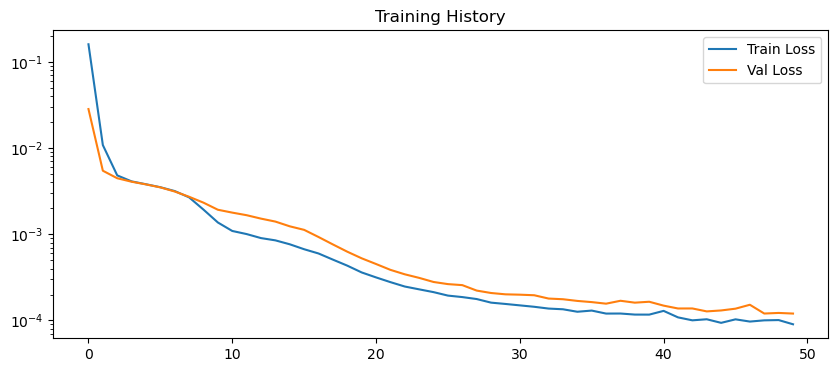

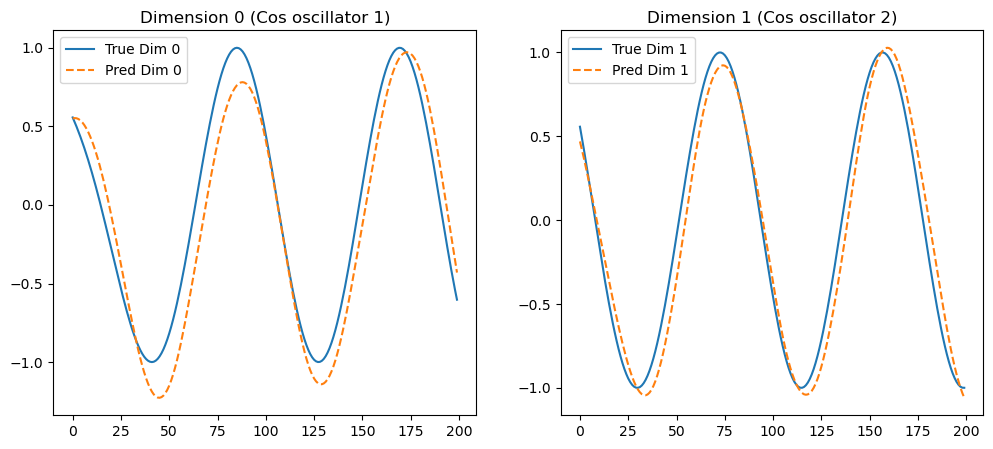

AttributeError: module 'torch.mps' has no attribute 'is_available'

In [4]:
import numpy as np
import torch
from pysr import PySRRegressor

# ==========================================
# 1. 准备训练数据
# ==========================================
# 我们需要从训练好的模型中采样一批输入输出对
# 为了提高回归质量，建议采样覆盖整个相空间的点

def sample_model_io(model, dataloader, num_samples=2000):
    model.eval()
    device = next(model.parameters()).device
    
    X_input_list = []
    G_latent_list = []
    Omega_list = [] # 动力学参数
    
    count = 0
    with torch.no_grad():
        for batch_x in dataloader:
            x = batch_x[0].to(device) # [B, T, D]
            # 我们只取 t=0 时刻的状态进行映射分析
            x0 = x[:, 0, :]
            
            # 1. 获取 Latent State (Encoder)
            g = model.encoder(x0)
            
            # 2. 获取 Dynamics Params (Omega Nets)
            # omegas 是一个 list，我们需要把它展平成一个向量
            omegas = model.get_omegas(g)
            # 展平处理: omegas 包含 [Batch, 2] (complex) 和 [Batch, 1] (real)
            # 我们将其拼接成 [Batch, n_params]
            omega_flat = torch.cat(omegas, dim=1)
            
            X_input_list.append(x0.cpu().numpy())
            G_latent_list.append(g.cpu().numpy())
            Omega_list.append(omega_flat.cpu().numpy())
            
            count += x0.shape[0]
            if count >= num_samples:
                break
                
    X_data = np.concatenate(X_input_list, axis=0)[:num_samples]
    G_data = np.concatenate(G_latent_list, axis=0)[:num_samples]
    Omega_data = np.concatenate(Omega_list, axis=0)[:num_samples]
    
    return X_data, G_data, Omega_data

print("Sampling data from trained model...")
# 假设 train_loader 已经在上下文中
X_np, G_np, Omega_np = sample_model_io(model, train_loader, num_samples=3000)
print(f"Sampled shapes: X={X_np.shape}, G={G_np.shape}, Omega={Omega_np.shape}")

# ==========================================
# 2. 配置 PySR
# ==========================================
default_pysr_params = dict(
    populations=40,
    model_selection="best",
    niterations=40, # 迭代次数越多越精确，但越慢
    # 选择适合动力系统的算子
    binary_operators=["+", "-", "*", "/"],
    unary_operators=[
        "cos", "sin", "square", "cube"
        # "exp", "tanh" # 根据需要开启，Kuramoto 主要是三角函数
    ],
    maxsize=25, # 限制公式复杂度
    verbosity=0,
    procs=4, # 并行核心数
)

# ==========================================
# 3. 任务 A: 提取 Encoder (X -> G)
# ==========================================
print("\n=== 1. Symbolic Regression for ENCODER (x -> g) ===")
# 我们通常逐维度回归，因为每个 latent dimension 可能由不同的物理量组成
# 输入: 观测状态 X_np (例如 8维: cos1, sin1, cos2, sin2...)
# 输出: 潜在状态 G_np (例如 6维)

encoder_eqs = []
latent_dim = G_np.shape[1]

for i in range(latent_dim):
    print(f"--- Fitting Latent Dimension g_{i} ---")
    model_sr = PySRRegressor(**default_pysr_params)
    model_sr.fit(X_np, G_np[:, i])
    
    eq = model_sr.sympy()
    encoder_eqs.append(eq)
    print(f"g_{i} = {eq}")

# ==========================================
# 4. 任务 B: 提取 Dynamics (G -> Omega/K)
# ==========================================
print("\n=== 2. Symbolic Regression for DYNAMICS (Auxiliary Nets: g -> omega) ===")
# 输入: 潜在状态 r^2 (DeepKoopman 结构中辅助网络输入的是半径平方) 或直接用 g
# 注意: 在 DeepKoopman 代码中，辅助网络的输入比较特殊：
# - 复数对的辅助网络输入是 r^2 = g_2k^2 + g_{2k+1}^2
# - 实数的辅助网络输入是 g_k
# 为了发现最原本的规律，我们直接尝试拟合 g -> omega 参数

dynamics_eqs = []
num_params = Omega_np.shape[1]

for i in range(num_params):
    print(f"--- Fitting Dynamics Parameter p_{i} (Freq/Growth) ---")
    # 这里我们只用相关的 latent variable 可能会更好，但全输入通用性更强
    model_sr = PySRRegressor(**default_pysr_params)
    model_sr.fit(G_np, Omega_np[:, i])
    
    eq = model_sr.sympy()
    dynamics_eqs.append(eq)
    print(f"param_{i} = {eq}")

# ==========================================
# 5. 任务 C: 提取 Decoder (G -> X)
# ==========================================
print("\n=== 3. Symbolic Regression for DECODER (g -> x) ===")
# 输入: 潜在状态 G_np
# 输出: 重构观测状态 X_np

decoder_eqs = []
input_dim = X_np.shape[1]

for i in range(input_dim):
    print(f"--- Fitting Observable Dimension x_{i} ---")
    model_sr = PySRRegressor(**default_pysr_params)
    model_sr.fit(G_np, X_np[:, i])
    
    eq = model_sr.sympy()
    decoder_eqs.append(eq)
    print(f"x_{i} = {eq}")

# ==========================================
# 6. 汇总报告
# ==========================================
print("\n" + "="*40)
print("FINAL SYMBOLIC DISCOVERY REPORT")
print("="*40)

print("\n[Encoder Functions]:")
variable_names_x = [f"x{i}" for i in range(X_np.shape[1])]
for i, eq in enumerate(encoder_eqs):
    print(f"g[{i}] = {eq}")

print("\n[Dynamics Parameters (K matrix elements)]:")
# Omega 输出解释:
# 对于复数对 j: param_2j = Frequency, param_2j+1 = Growth Rate
# 对于实数 k:   param = Growth Rate
variable_names_g = [f"g{i}" for i in range(G_np.shape[1])]
for i, eq in enumerate(dynamics_eqs):
    print(f"K_param[{i}] = {eq}")

print("\n[Decoder Functions]:")
for i, eq in enumerate(decoder_eqs):
    print(f"x[{i}] = {eq}")

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Sampling data from trained model...
Sampled shapes: X=(1592, 8), G=(1592, 6), Omega=(1592, 6)

=== 1. Symbolic Regression for ENCODER (x -> g) ===
--- Fitting Latent Dimension g_0 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


g_0 = (x4 + x7/1.7143139)/0.9589132 - 0.36004773*x3/cos((x7*1.3247957 + (x4 + x7)*(-0.39080334))**2)
--- Fitting Latent Dimension g_1 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


g_1 = (x4 - 2.423522*(x5 + sin(x1 + 0.027022216)*0.14078456))/1.2337226
--- Fitting Latent Dimension g_2 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


g_2 = sin(x3 - (x0 + x0 + x2*(-0.8104002) + (x3 - x4)*0.3683622 + 0.125642))*(-0.29554492) - 0.04098106
--- Fitting Latent Dimension g_3 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


g_3 = (x4*(-0.049214736)*x3 - 0.35229418)*(x4 + x7*(-0.61742514) - 0.04523233)
--- Fitting Latent Dimension g_4 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


g_4 = sin((0.013369621 + (-x6 + x7)**3/(x2 - 1*(-0.1041942)))*(x0 + x6))*1.6080958
--- Fitting Latent Dimension g_5 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


g_5 = (x1*(-1.1409711) + x3 - 0.57310545*x7 + 0.03181894)/(-1.0778168)

=== 2. Symbolic Regression for DYNAMICS (Auxiliary Nets: g -> omega) ===
--- Fitting Dynamics Parameter p_0 (Freq/Growth) ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


param_0 = -x3*x4*(x2**3 - 1.7770249*x3*cos(x1)) + x5*0.0051761563 + 1.4863248
--- Fitting Dynamics Parameter p_1 (Freq/Growth) ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


param_1 = (-(x2*0.021295892 + cos(x5*(-0.7758558))) - sin(cos(x3)) + 1.9235444)*cos(x5)
--- Fitting Dynamics Parameter p_2 (Freq/Growth) ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


param_2 = sin(sin(x3**2*0.2746584 - sin(cos(x2)))) - 1*0.01927425
--- Fitting Dynamics Parameter p_3 (Freq/Growth) ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


param_3 = (-(-0.0699505)*x4 + (x0*(x0 + x1*cos(x1) + 0.3630852) + x2)*0.005380023 - 0.5368751)**3
--- Fitting Dynamics Parameter p_4 (Freq/Growth) ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


param_4 = -x4*((x4 - 0.134215136082746*cos(cos(x3 + x4 - 1*0.20970994))**2)*(-0.08498309) - 0.28982386) - 1.0418518
--- Fitting Dynamics Parameter p_5 (Freq/Growth) ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


param_5 = (sin(x5*0.37000087) + 0.12305131)*sin(cos(sin(sin(x5*(-0.33100137)))))*cos(sin(sin(sin(x5*(-0.3441142)))))

=== 3. Symbolic Regression for DECODER (g -> x) ===
--- Fitting Observable Dimension x_0 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_0 = (-sin(x3 - x4)**2 - 0.6758578)*(x1 + x2 + x5*(-1.3602179) - 0.018968044)
--- Fitting Observable Dimension x_1 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_1 = 0.0030615632 + (x0*sin(x5)**2 + x0/0.601735 + x1 + x3)*(-0.31094787)
--- Fitting Observable Dimension x_2 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_2 = x0*(-0.3904265) + x1*(-0.47137025) - 0.42704773*x3 + (0.1785664 - x3)**4
--- Fitting Observable Dimension x_3 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_3 = x3**3 - (x1*0.48017624 + x4*(-0.18725275) - (x0*(-0.26130447) - x5)) - 0.03190909
--- Fitting Observable Dimension x_4 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_4 = ((x4 + sin(x1)*sin(x0 - 1*(-0.47451568)))*x2*(-0.16185784) + x2 - (-1.3838667)*(x0 - x4))*0.40229416
--- Fitting Observable Dimension x_5 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_5 = -x5 + (1.3278658 - sin(x1*(x3 + x4))**2)*(x2*4.4501247/(1.5223136 - (-16.951786)*x2*x5) - x3)
--- Fitting Observable Dimension x_6 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_6 = x0*0.07773491 - 0.3878803*(x1 - (x0 - x2 + (x5 + sin(x4*(-1.0066168)))/(-3.1632187))) - 0.009709233
--- Fitting Observable Dimension x_7 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_7 = (x0*0.7434895 + sin(x1*(-0.24936023) + x3 + x4 - x5 - 0.04122119))*0.7586983

FINAL SYMBOLIC DISCOVERY REPORT

[Encoder Functions]:
g[0] = (x4 + x7/1.7143139)/0.9589132 - 0.36004773*x3/cos((x7*1.3247957 + (x4 + x7)*(-0.39080334))**2)
g[1] = (x4 - 2.423522*(x5 + sin(x1 + 0.027022216)*0.14078456))/1.2337226
g[2] = sin(x3 - (x0 + x0 + x2*(-0.8104002) + (x3 - x4)*0.3683622 + 0.125642))*(-0.29554492) - 0.04098106
g[3] = (x4*(-0.049214736)*x3 - 0.35229418)*(x4 + x7*(-0.61742514) - 0.04523233)
g[4] = sin((0.013369621 + (-x6 + x7)**3/(x2 - 1*(-0.1041942)))*(x0 + x6))*1.6080958
g[5] = (x1*(-1.1409711) + x3 - 0.57310545*x7 + 0.03181894)/(-1.0778168)

[Dynamics Parameters (K matrix elements)]:
K_param[0] = -x3*x4*(x2**3 - 1.7770249*x3*cos(x1)) + x5*0.0051761563 + 1.4863248
K_param[1] = (-(x2*0.021295892 + cos(x5*(-0.7758558))) - sin(cos(x3)) + 1.9235444)*cos(x5)
K_param[2] = sin(sin(x3**2*0.2746584 - sin(cos(x2)))) - 1*0.01927425
K_param[3] = (-(-0.0699505)*x4 + (x0*(x0 + x1*cos(x1) + 0.363